In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = ['Malgun Gothic']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
class SimpleARIMA:
    def __init__(self, data, column_name):
        if isinstance(data, pd.DataFrame):
            self.ts_data = data[column_name]
        else:
            self.ts_data = data        
        self.model = None
        self.best_order = None
    
    def check_stationarity(self):
        print("=== 정상성 검정 ===")
        
        adf_result = adfuller(self.ts_data.dropna())
        print(f"원시 데이터 ADF p-value: {adf_result[1]:.6f}")
        
        if adf_result[1] > 0.05:
            print("비정상 시계열, 차분 필요")
            diff_data = self.ts_data.diff().dropna()
            adf_diff = adfuller(diff_data)
            print(f"1차 차분 ADF p-value: {adf_diff[1]:.6f}")
            
            if adf_diff[1] <= 0.05:
                print("1차 차분으로 정상성 확보")
                return 1 
        else:
            print("정상 시계열")
            return 0
    
    def plot_diagnostics(self, d=1):
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        axes[0,0].plot(self.ts_data)
        axes[0,0].set_title('원시 시계열')
        axes[0,0].grid(True, alpha=0.3)
        
        if d > 0:
            diff_data = self.ts_data.diff().dropna()
            axes[0,1].plot(diff_data)
            axes[0,1].set_title('1차 차분')
            axes[0,1].grid(True, alpha=0.3)
            
            plot_acf(diff_data, ax=axes[1,0], lags=20, title='ACF (차분)')
            plot_pacf(diff_data, ax=axes[1,1], lags=20, title='PACF (차분)')
        
        plt.tight_layout()
        plt.show()
    
    def find_best_order(self, max_p=3, max_q=3, d=1):
        print("\n=== 최적 모델 탐색 ===")
        
        best_aic = float('inf')
        best_order = None
        
        for p in range(max_p + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(self.ts_data, order=(p, d, q))
                    fitted = model.fit()
                    
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                        
                except:
                    continue
        
        print(f"최적 모델: ARIMA{best_order}")
        print(f"최적 AIC: {best_aic:.2f}")
        
        self.best_order = best_order
        return best_order
    
    def fit_model(self):
        print(f"\n=== ARIMA{self.best_order} 모델 학습 ===")
        
        self.model = ARIMA(self.ts_data, order=self.best_order)
        self.fitted_model = self.model.fit()
        
        print("모델 계수:")
        print(self.fitted_model.params)
        
        return self.fitted_model
    
    def check_residuals(self):
        residuals = self.fitted_model.resid

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        axes[0].plot(residuals)
        axes[0].set_title('잔차 시계열')
        axes[0].grid(True, alpha=0.3)
        
        axes[1].hist(residuals, bins=20, alpha=0.7)
        axes[1].set_title('잔차 분포')
        axes[1].grid(True, alpha=0.3)
        
        plot_acf(residuals, ax=axes[2], lags=15, title='잔차 ACF')
        plt.tight_layout()
        plt.show()
    
    def forecast(self, steps=10):
        print(f"\n=== {steps}일 예측 ===")
        
        forecast_result = self.fitted_model.forecast(steps=steps)
        forecast_ci = self.fitted_model.get_forecast(steps=steps).conf_int()
        
        for i in range(min(5, steps)):
            print(f"{i+1}일 후: {forecast_result.iloc[i]:.2f} "
                  f"(95% CI: {forecast_ci.iloc[i,0]:.2f} - {forecast_ci.iloc[i,1]:.2f})")
        
        return forecast_result, forecast_ci
    
    def plot_forecast(self, forecast_result, forecast_ci, steps=10):
        plt.figure(figsize=(12, 6))
        
        # 최근 데이터 (마지막 50개)
        recent_data = self.ts_data.tail(50)
        plt.plot(recent_data.index, recent_data.values, 
                label='실제 데이터', linewidth=2)
        
        # 예측 구간 생성
        last_date = self.ts_data.index[-1]
        if isinstance(last_date, str):
            future_dates = range(len(self.ts_data), len(self.ts_data) + steps)
        else:
            future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                       periods=steps, freq='D')
        
        # 예측 결과
        plt.plot(future_dates, forecast_result, 
                label=f'{steps}일 예측', linewidth=2, color='red', linestyle='--')
        
        # 신뢰구간
        plt.fill_between(future_dates, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1],
                        color='red', alpha=0.2, label='95% 신뢰구간')
        
        plt.title(f'ARIMA{self.best_order} 시계열 예측')
        plt.xlabel('시간')
        plt.ylabel('값')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def simple_backtest(self, test_size=30):
        print(f"\n=== 백테스트 (최근 {test_size}개) ===")
        
        train_data = self.ts_data[:-test_size]
        test_data = self.ts_data[-test_size:]
        
        # 훈련 데이터로 모델 재학습
        temp_model = ARIMA(train_data, order=self.best_order)
        temp_fitted = temp_model.fit()
        
        # 예측
        predictions = temp_fitted.forecast(steps=test_size)
        
        # 성능 평가
        mape = mean_absolute_percentage_error(test_data, predictions) * 100
        print(f"MAPE: {mape:.2f}%")
        
        # 시각화
        plt.figure(figsize=(12, 6))
        plt.plot(test_data.index, test_data.values, label='실제값', linewidth=2)
        plt.plot(test_data.index, predictions, label='예측값', linewidth=2, alpha=0.8)
        plt.title(f'백테스트 결과 (MAPE: {mape:.2f}%)')
        plt.xlabel('시간')
        plt.ylabel('값')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return mape

=== 정상성 검정 ===
원시 데이터 ADF p-value: 0.612490
비정상 시계열, 차분 필요
1차 차분 ADF p-value: 0.000005
1차 차분으로 정상성 확보


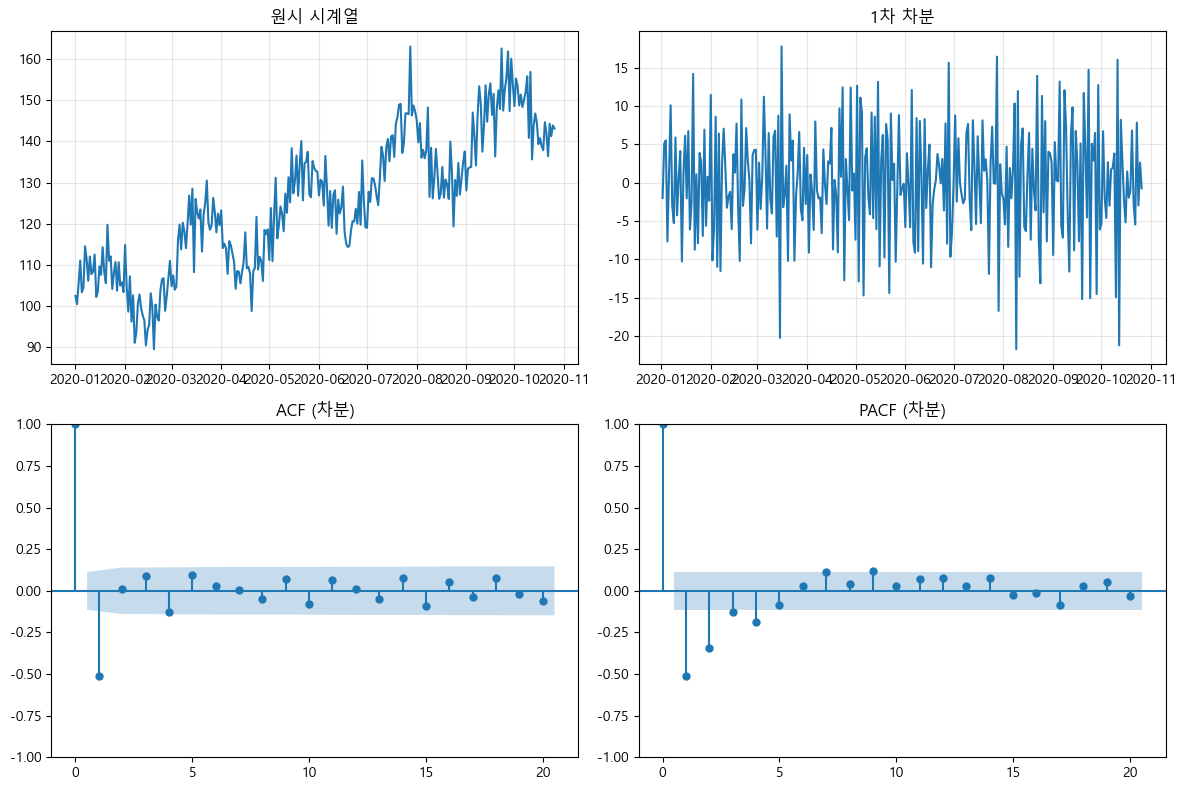


=== 최적 모델 탐색 ===
최적 모델: ARIMA(1, 1, 2)
최적 AIC: 1886.86

=== ARIMA(1, 1, 2) 모델 학습 ===
모델 계수:
ar.L1      0.881306
ma.L1     -1.701616
ma.L2      0.779461
sigma2    31.232505
dtype: float64


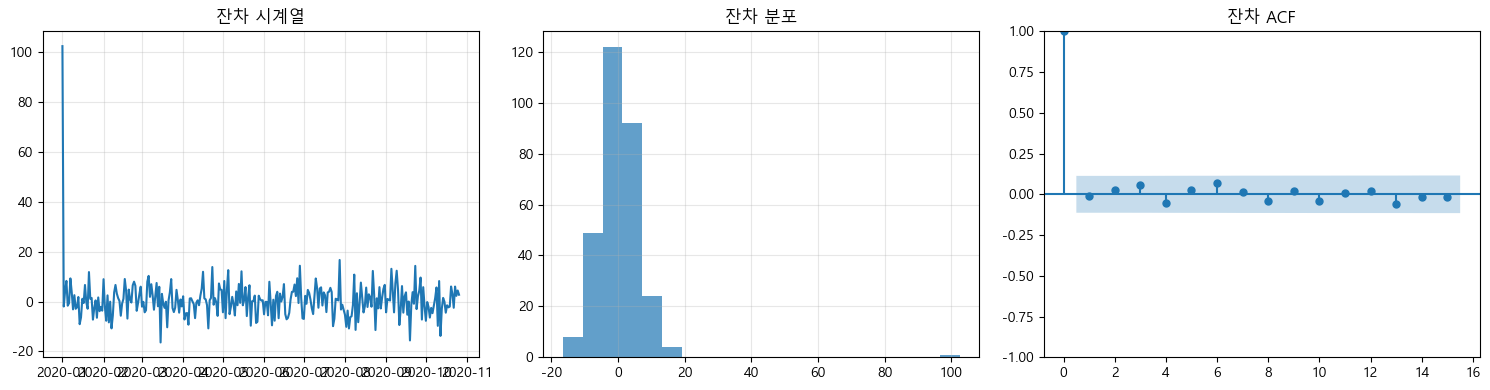


=== 10일 예측 ===
1일 후: 141.33 (95% CI: 130.38 - 152.29)
2일 후: 141.83 (95% CI: 130.71 - 152.96)
3일 후: 142.28 (95% CI: 130.85 - 153.70)
4일 후: 142.67 (95% CI: 130.82 - 154.51)
5일 후: 143.01 (95% CI: 130.62 - 155.40)


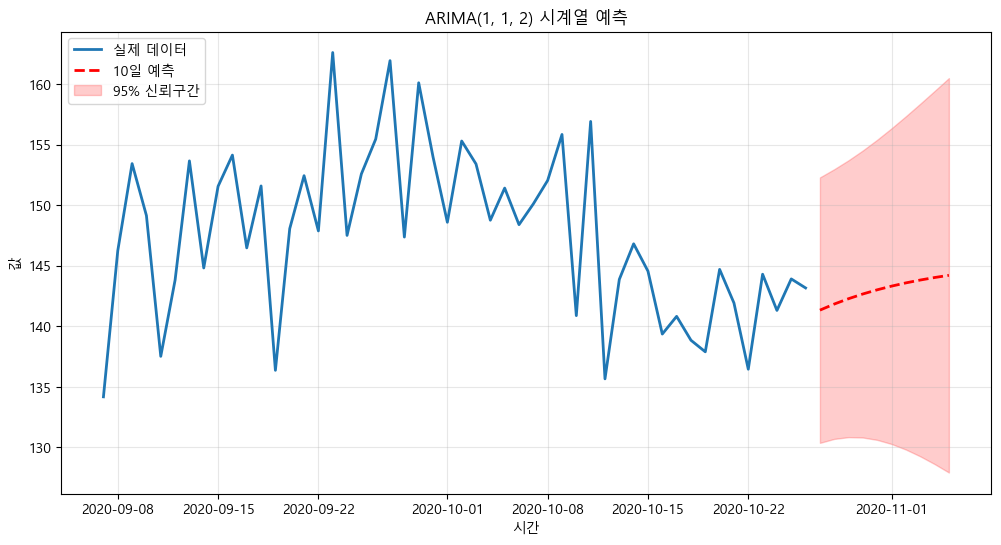


=== 백테스트 (최근 30개) ===
MAPE: 5.42%


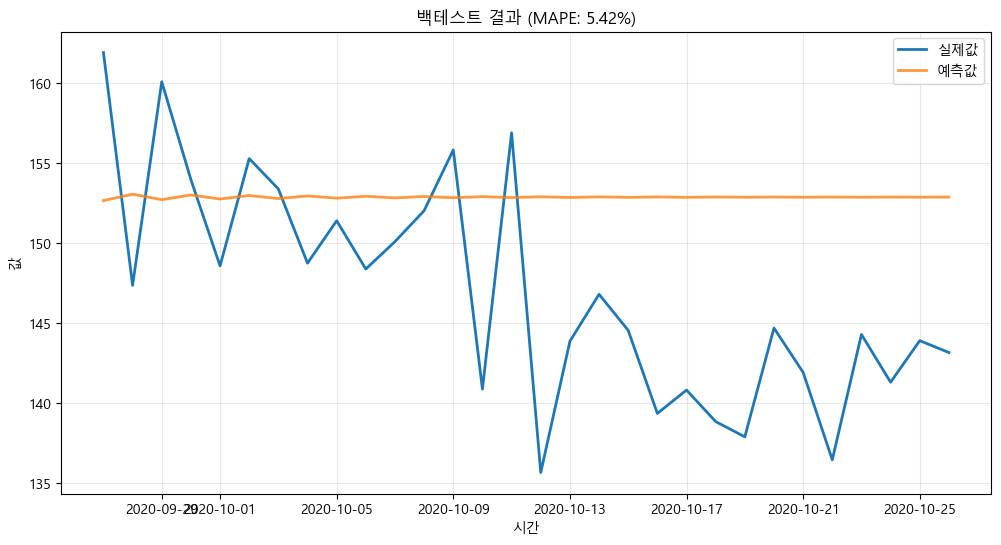

In [3]:
# def run_arima_example(data, column_name='value'):
#     # 1. 모델 초기화
    
#     return arima

# 샘플 시계열 데이터 생성
np.random.seed(42)
dates = pd.date_range('2020-01-01', periods=300, freq='D')

# 트렌드 + 노이즈가 있는 시계열
trend = np.linspace(100, 150, 300)
noise = np.random.normal(0, 5, 300)
ts_data = trend + noise + np.sin(np.arange(300) * 0.1) * 10

sample_data = pd.DataFrame({
    'date': dates,
    'value': ts_data
}).set_index('date')

# 1. 모델 초기화
arima = SimpleARIMA(sample_data, column_name="value")

# 2. 정상성 검정
d = arima.check_stationarity()

# 3. 진단 플롯
arima.plot_diagnostics(d)

# 4. 최적 차수 찾기
arima.find_best_order(d=d)

# 5. 모델 학습
arima.fit_model()

# 6. 잔차 진단
arima.check_residuals()

# 7. 예측
forecast_result, forecast_ci = arima.forecast(steps=10)

# 8. 예측 시각화
arima.plot_forecast(forecast_result, forecast_ci)

# 9. 백테스트
mape = arima.simple_backtest()